In [147]:
import mne
import numpy as np
from mne.time_frequency import tfr_morlet
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
import mne
import glob
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from mne.viz import plot_compare_evokeds
from tqdm import tqdm 

### Things modified :
     Before) Took out all code for 5, 9, 13, as we are taking those out of the hypothesis
     After) Added 5, 9, 13 again as conjunction was not working 

# For loop for multiple patients

In [148]:
#ONLY DID FOR 'CC' = could add 'CA' and 'CS'
conj_conditions = {
    'a5/cc': 5,
    'a9/cc': 9,
    'at/cc': 13
} #used a dictionary to make it simpler

# ROIs
roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

# Frequency bands
bands = {'alpha': (8, 13), 'gamma': (30, 45)}

# Final results
all_measures = []

# Epoch files
epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]

for filepath in epoch_files:
    ep = mne.read_epochs(filepath, preload=True)
    ep.apply_baseline(baseline=(-0.2, 0))

    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'

    for cond_suffix, set_size in conj_conditions.items():
        condition_keys = [key for key in ep.event_id.keys() if key.endswith(cond_suffix)]
        if not condition_keys:
            continue

        condition_epochs = ep[condition_keys]

        # Average evoked for ROI
        evoked = condition_epochs.average(picks=roi_channels)
        n1_chan, n1_lat, n1_amp = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
        p3b_chan, p3b_lat, p3b_amp = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

        # PSD
        picks = mne.pick_types(condition_epochs.info, eeg=True)
        psd = condition_epochs.compute_psd(method='multitaper', fmin=1, fmax=40, picks=picks)
        psds, freqs = psd.get_data(return_freqs=True)
        avg_psd = psds.mean(axis=0)
        picked_ch_names = [condition_epochs.ch_names[i] for i in picks]
        psd_df = pd.DataFrame(avg_psd, index=picked_ch_names, columns=freqs)

        # Band powers
        band_powers = {}
        valid_roi_channels = list(set(roi_channels).intersection(psd_df.index))
        for band_name, (fmin, fmax) in bands.items():
            if valid_roi_channels:
                band_power = psd_df.loc[valid_roi_channels, (psd_df.columns > fmin) & (psd_df.columns < fmax)].mean().mean()
            else:
                band_power = None
            band_powers[band_name] = band_power

        # Append to results
        all_measures.append({
            'subject': subject_id,
            'diagnosis': diagnosis,
            'set_size': set_size,
            'N1_amp': n1_amp,
            'N1_lat': n1_lat,
            'N1_chan': n1_chan,
            'P3b_amp': p3b_amp,
            'P3b_lat': p3b_lat,
            'P3b_chan': p3b_chan,
            'alpha_power': band_powers.get('alpha'),
            'gamma_power': band_powers.get('gamma')
        })

# Final DataFrame
results_df = pd.DataFrame(all_measures)
results_df


Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimat

,subject,diagnosis,set_size,N1_amp,N1_lat,N1_chan,P3b_amp,P3b_lat,P3b_chan,alpha_power,gamma_power
0,1109P,asd,5,-0.000006,0.140,E87,0.000020,0.378,E59,3.243293e-09,1.157568e-10
1,1109P,asd,9,-0.000012,0.118,E87,0.000019,0.312,E59,2.500041e-09,1.245039e-10
2,1109P,asd,13,-0.000009,0.128,E87,0.000018,0.400,E59,3.056893e-09,1.087700e-10
3,1109M1,control,5,-0.000004,0.132,E87,0.000005,0.432,E59,6.922079e-10,7.534543e-11
4,1109M1,control,9,-0.000008,0.125,E53,0.000005,0.397,E92,8.221113e-10,7.696529e-11
5,1109M1,control,13,-0.000006,0.096,E53,0.000003,0.308,E87,8.221502e-10,7.397062e-11


Processing /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


Processing /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished


    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished


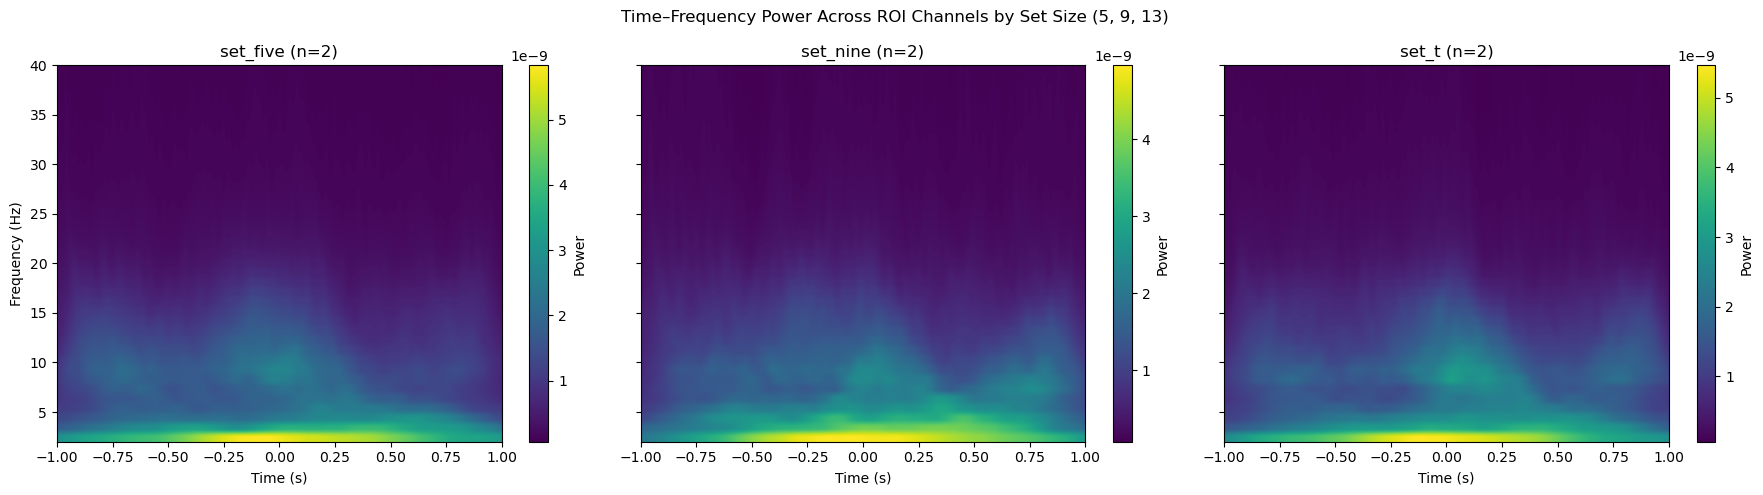

In [149]:
condition_sets_by_size = {
    'set_five': [
        'vs/display/search/a5/cs',
        'vs/display/search/a5/ca',
        'vs/display/search/a5/cc'
    ],
    'set_nine': [
        'vs/display/search/a9/cs',
        'vs/display/search/a9/ca',
        'vs/display/search/a9/cc'
    ],
    'set_t': [
        'vs/display/search/at/cs',
        'vs/display/search/at/ca',
        'vs/display/search/at/cc'
    ]
}

epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]

roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

freqs = np.arange(2, 41, 1)
n_cycles = 4

tfr_by_set_size = {key: [] for key in condition_sets_by_size}

for filepath in epoch_files:
    print(f"Processing {filepath}")
    ep = mne.read_epochs(filepath, preload=True)

    for set_label, cond_list in condition_sets_by_size.items():
        valid_conds = [cond for cond in cond_list if cond in ep.event_id]
        if not valid_conds:
            continue

        cond_epochs = ep[valid_conds].copy().pick_channels(roi_channels)

        tfr = mne.time_frequency.tfr_multitaper(
            cond_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            use_fft=True,
            return_itc=False,
            average=True
        )

        roi_mean = tfr.data.mean(axis=0)  # shape: (n_freqs, n_times)
        tfr_by_set_size[set_label].append(roi_mean)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
times = tfr.times

for i, set_label in enumerate(['set_five', 'set_nine', 'set_t']):
    data_list = tfr_by_set_size[set_label]
    if data_list:
        mean_power = np.mean(data_list, axis=0)

        im = axes[i].imshow(
            mean_power, aspect='auto', origin='lower',
            extent=[times[0], times[-1], freqs[0], freqs[-1]],
            cmap='viridis'
        )

        axes[i].set_title(f"{set_label} (n={len(data_list)})")
        axes[i].set_xlabel('Time (s)')
        if i == 0:
            axes[i].set_ylabel('Frequency (Hz)')

        fig.colorbar(im, ax=axes[i], orientation='vertical', label='Power')

plt.suptitle("Time–Frequency Power Across ROI Channels by Set Size (5, 9, 13)")
plt.tight_layout()
plt.show()

Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. N

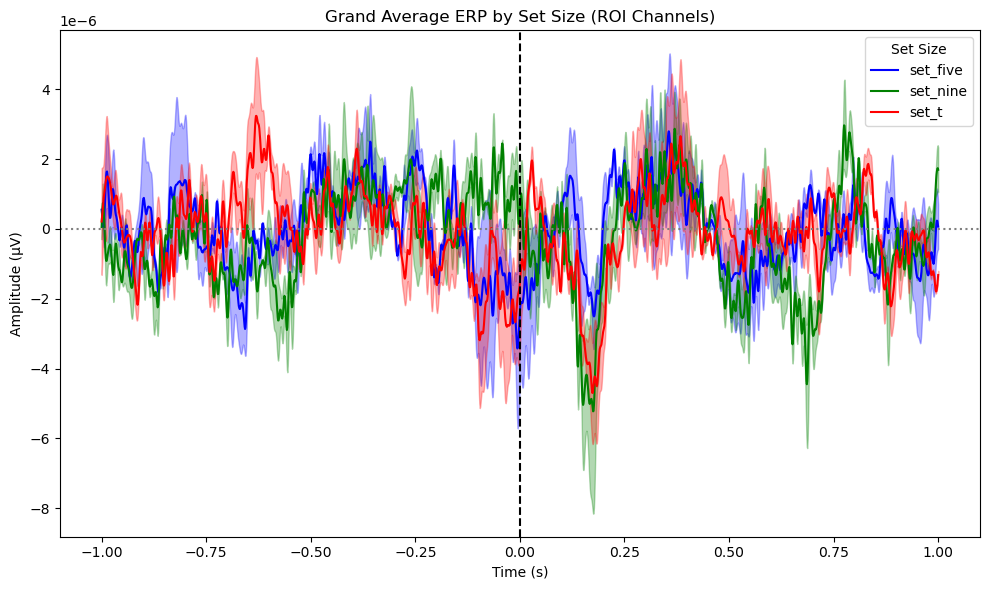

In [153]:
erp_by_setsize = {'set_five': [], 'set_nine': [], 'set_t': []}

for filepath in epoch_files:
    ep = mne.read_epochs(filepath, preload=True)
    # Original colors dict
    colors = {
        'Set Size 5': 'blue',
        'Set Size 9': 'green',
        'Set Size 13': 'red'
    }
    # Create a new dictionary with standardized keys
    colors = {
        'set_five': colors['Set Size 5'],
        'set_nine': colors['Set Size 9'],
        'set_t': colors['Set Size 13']
    }
    for set_label, conds in condition_sets_by_size.items():
        existing = [c for c in conds if c in ep.event_id]
        if not existing:
            continue
        epochs = ep[existing].copy().pick_channels(roi_channels)
        # Average across ROI channels and then across epochs
        erp_data = epochs.get_data().mean(axis=1).mean(axis=0)  # shape: (n_times,)
        erp_by_setsize[set_label].append(erp_data)


times = ep.times
plt.figure(figsize=(10, 6))

for set_label in ['set_five', 'set_nine', 'set_t']:
    data = np.vstack(erp_by_setsize[set_label])  # shape: (n_subjects, n_times)
    mean = data.mean(axis=0)
    sem = data.std(axis=0) / np.sqrt(data.shape[0])
    plt.plot(times, mean, label=set_label, color=colors[set_label])
    plt.fill_between(times, mean - sem, mean + sem, color=colors[set_label], alpha=0.3)

plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='gray', linestyle=':')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("Grand Average ERP by Set Size (ROI Channels)")
plt.legend(title="Set Size")
plt.tight_layout()
plt.show()

In [154]:
print(colors.keys())

dict_keys(['set_five', 'set_nine', 'set_t'])


In [155]:
trial_counts = []

for filepath in epoch_files:
    print(f"\nChecking file: {filepath}")
    ep = mne.read_epochs(filepath, preload=False)

    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]
    subject_counts = {'subject': subject_id}

    for size_label, cond_list in condition_sets_by_size.items():
        existing_conds = [c for c in cond_list if c in ep.event_id]

        if not existing_conds:
            subject_counts[size_label] = 0
            continue

        n_epochs = sum(len(ep[c]) for c in existing_conds)
        subject_counts[size_label] = n_epochs
        print(f"{size_label} trials: {n_epochs}")

    trial_counts.append(subject_counts)

# --- Create summary DataFrame ---
counts_df = pd.DataFrame(trial_counts)
print("\n Trial counts per subject:")
print(counts_df)


Checking file: /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
set_five trials: 10
set_nine trials: 8
set_t trials: 9

Checking file: /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
set_five trials: 10
set_nine trials: 9
set_t trials: 8

 Trial counts per subject:
  subject  set_five  set_nine  set_t

# Plot ERPs for different distractor number

In [117]:

epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]

roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

bands = {'alpha': (8, 13), 'gamma': (30, 45)}

all_measures = []

for filepath in epoch_files:
    print(f"Processing {filepath}")
    ep = mne.read_epochs(filepath, preload=True)

    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'

    for setsize_label, cond_list in condition_sets_by_size.items():
        existing_conds = [c for c in cond_list if c in ep.event_id]
        if not existing_conds:
            print(f"No {setsize_label} conditions found in {filepath}, skipping.")
            continue

        condition_epochs = ep[existing_conds]

        # Average evoked for ROI channels
        evoked = condition_epochs.average(picks=roi_channels)

        # Get N1 and P3b peaks
        n1_chan, n1_lat, n1_amp = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
        p3_chan, p3_lat, p3_amp = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

        # Compute PSD using multitaper
        picks = mne.pick_types(condition_epochs.info, eeg=True)
        psd = condition_epochs.compute_psd(method='multitaper', fmin=1, fmax=40, picks=picks)
        psds, freqs = psd.get_data(return_freqs=True)
        avg_psd = psds.mean(axis=0)
        picked_ch_names = [condition_epochs.ch_names[i] for i in picks]
        psd_df = pd.DataFrame(avg_psd, index=picked_ch_names, columns=freqs)

        # Band power on ROI channels
        band_powers = {}
        try:
            valid_roi = list(set(roi_channels).intersection(psd_df.index))
            for band_name, (fmin, fmax) in bands.items():
                if valid_roi:
                    band_power = psd_df.loc[valid_roi, (psd_df.columns > fmin) & (psd_df.columns < fmax)].mean().mean()
                else:
                    band_power = None
                band_powers[band_name] = band_power
        except Exception as e:
            print(f"Band power error for {subject_id} in {setsize_label}: {e}")
            band_powers = {'alpha': None, 'gamma': None}

        # Append all measures
        all_measures.append({
            'subject': subject_id,
            'diagnosis': diagnosis,
            'set_size': setsize_label,
            'N1_amp': n1_amp,
            'N1_lat': n1_lat,
            'N1_chan': n1_chan,
            'P3b_amp': p3_amp,
            'P3b_lat': p3_lat,
            'P3b_chan': p3_chan,
            'alpha_power': band_powers.get('alpha'),
            'gamma_power': band_powers.get('gamma'),
        })

# --- Final DataFrame ---
results_df = pd.DataFrame(all_measures)
results_df

Processing /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Processing /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
 

,subject,diagnosis,set_size,N1_amp,N1_lat,N1_chan,P3b_amp,P3b_lat,P3b_chan,alpha_power,gamma_power
0,1109P,asd,set_five,-0.000006,0.080,E59,0.000014,0.379,E59,3.114442e-09,1.158831e-10
1,1109P,asd,set_nine,-0.000008,0.140,E53,0.000013,0.381,E59,2.453184e-09,1.239501e-10
2,1109P,asd,set_t,-0.000009,0.128,E87,0.000012,0.400,E59,3.056893e-09,1.087700e-10
3,1109M1,control,set_five,-0.000004,0.132,E53,0.000004,0.433,E59,5.938581e-10,7.862008e-11
4,1109M1,control,set_nine,-0.000006,0.125,E53,0.000005,0.399,E92,7.852382e-10,7.110156e-11
5,1109M1,control,set_t,-0.000005,0.131,E59,0.000002,0.308,E87,8.221502e-10,7.397062e-11


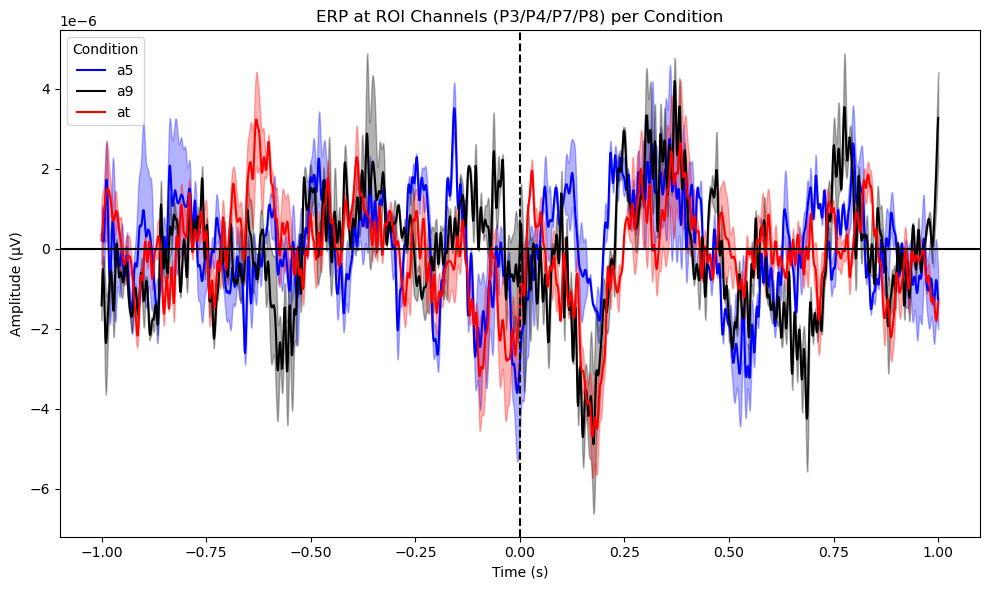

In [156]:
# Plotting
times = ep.times
plt.figure(figsize=(10, 6))

colors = {
    'vs/display/search/a5/cc': 'blue',
    'vs/display/search/a9/cc': 'black',
    'vs/display/search/at/cc': 'red'
}

for cond, waveforms in condition_erps.items():
    data = np.array(waveforms)  # shape: (n_subjects, n_times)
    mean = data.mean(axis=0)
    sem = data.std(axis=0) / np.sqrt(data.shape[0])
    
    plt.plot(times, mean, label=cond.split('/')[-2], color=colors[cond])
    plt.fill_between(times, mean - sem, mean + sem, color=colors[cond], alpha=0.3)

plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("ERP at ROI Channels (P3/P4/P7/P8) per Condition")
plt.legend(title="Condition")
plt.tight_layout()
plt.show()

## Get files

In [157]:

#epoch_files = glob.glob(file_pattern)
print(f"Found {len(epoch_files)} files to process")
#Select where to save the data
# Main results storage
all_results = []           # ERP components and spectral power
all_erp_data = []         # ERP waveforms for plotting
quality_issues = defaultdict(list)  # Track data quality problems

# Time-frequency analysis storage
all_tfr_data = []         # Time-frequency representations

Found 2 files to process


In [158]:
#Helper functions
def extract_subject_info(filepath):
    filename = filepath.split('/')[-1]
    subject_id = filename.split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'
    return subject_id, diagnosis

def compute_spectral_power_mne(epochs, roi_channels, freq_bands):
    """Compute spectral power using MNE functions"""
    # Pick ROI channels
    roi_epochs = epochs.copy().pick_channels(roi_channels)
    
    # Compute PSD using MNE
    psd = roi_epochs.compute_psd(method='welch', fmin=1, fmax=50, verbose=False)
    psds, freqs = psd.get_data(return_freqs=True)
    
    # Average across trials and channels
    avg_psd = psds.mean(axis=(0, 1))  # Shape: (n_freqs,)
    
    # Calculate band power
    band_powers = {}
    for band_name, (fmin, fmax) in freq_bands.items():
        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        if np.any(freq_mask):
            band_power = avg_psd[freq_mask].mean()
            band_powers[f'{band_name}_power'] = band_power
        else:
            band_powers[f'{band_name}_power'] = np.nan
    
    return band_powers

In [159]:
# Main processing loop
for i, filepath in enumerate(tqdm(epoch_files, desc="Processing files")):
    print(f"Processing file {i+1}/{len(epoch_files)}: {filepath.split('/')[-1]}")
    
    try:
        # Load epochs
        epochs = mne.read_epochs(filepath, preload=True, verbose=False)
        
        # Define set size condition groups using precise matching
        set_size_conditions = {
            'set_five': [key for key in epochs.event_id if key.startswith('vs/display/search/a5/')],
            'set_nine': [key for key in epochs.event_id if key.startswith('vs/display/search/a9/')],
            'set_t': [key for key in epochs.event_id if key.startswith('vs/display/search/at/')],
        }
        
        # Extract subject info
        subject_id, diagnosis = extract_subject_info(filepath)
        
        # Apply baseline correction once
        epochs = epochs.apply_baseline(baseline_window)
        
        # Process each set size group
        for group_name, condition_keys in set_size_conditions.items():
            # Filter for conditions that actually exist in this subject
            existing_conditions = [c for c in condition_keys if c in epochs.event_id]
            
            if not existing_conditions:
                quality_issues[subject_id].append(f"No {group_name} conditions found")
                continue
            
            # Select relevant epochs
            size_epochs = epochs[existing_conditions]
            n_trials = len(size_epochs)
            
            # Trial count check
            if n_trials < min_trials:
                quality_issues[subject_id].append(f"Low trial count {group_name}: {n_trials}")
                print(f" Warning: Only {n_trials} trials for {group_name}")
            
            # Select ROI channels and average
            roi_epochs = size_epochs.copy().pick_channels(roi_channels)
            evoked = roi_epochs.average()
            evoked.comment = f"{subject_id}_{group_name}"
            
            # ERP peak extraction
            try:
                n1_channel, n1_lat, n1_amp = evoked.get_peak(
                    tmin=n1_window[0], tmax=n1_window[1], mode='neg', return_amplitude=True
                )
            except ValueError:
                n1_channel, n1_lat, n1_amp = np.nan, np.nan, np.nan
                quality_issues[subject_id].append(f"N1 not found: {group_name}")
            
            try:
                p3_channel, p3_lat, p3_amp = evoked.get_peak(
                    tmin=p3_window[0], tmax=p3_window[1], mode='pos', return_amplitude=True
                )
            except ValueError:
                p3_channel, p3_lat, p3_amp = np.nan, np.nan, np.nan
                quality_issues[subject_id].append(f"P3 not found: {group_name}")
            
            # Spectral band power
            band_powers = compute_spectral_power_mne(size_epochs, roi_channels, bands)
            
            # Store ERP waveform
            erp_waveform = {
                'subject': subject_id,
                'diagnosis': diagnosis,
                'set_size': group_name,
                'n_trials': n_trials,
                'times': evoked.times,
                'amplitude': evoked.data.mean(axis=0),
                'roi_channels': ','.join(roi_channels)
            }
            all_erp_data.append(erp_waveform)
            
            # Store ERP summary features
            result = {
                'subject': subject_id,
                'diagnosis': diagnosis,
                'set_size': group_name,
                'n_trials': n_trials,
                'roi_channels': ','.join(roi_channels),
                'N1_channel': n1_channel,
                'N1_amplitude': n1_amp,
                'N1_latency': n1_lat,
                'P3_channel': p3_channel,
                'P3_amplitude': p3_amp,
                'P3_latency': p3_lat,
                **band_powers
            }
            all_results.append(result)
    
    except Exception as e:
        print(f"  Error processing {filepath}: {e}")
        subject_id, _ = extract_subject_info(filepath)
        quality_issues[subject_id].append(f"Processing failed: {e}")

print(" Main processing completed!")

Processing files:   0%|                                   | 0/2 [00:00<?, ?it/s]

Processing file 1/2: sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  50%|█████████████▌             | 1/2 [00:03<00:03,  3.81s/it]

Processing file 2/2: sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files: 100%|███████████████████████████| 2/2 [00:06<00:00,  3.33s/it]

 Main processing completed!


In [161]:
# Create dataframe with ERP info from all_erp_data
erp_data_list = []

for erp_dict in all_erp_data:
    n_timepoints = len(erp_dict['times'])

    erp_df = pd.DataFrame({
        'time': erp_dict['times'],
        'amplitude': erp_dict['amplitude'],
        'subject': [erp_dict['subject']] * n_timepoints,
        'diagnosis': [erp_dict['diagnosis']] * n_timepoints,
        'set_size': [erp_dict['set_size']] * n_timepoints,  # this is the key change
        'n_trials': [erp_dict['n_trials']] * n_timepoints
    })

    erp_data_list.append(erp_df)

# Combine all into one DataFrame
if erp_data_list:
    erp_df = pd.concat(erp_data_list, ignore_index=True)
    print(f"ERP waveform data contains {len(erp_df)} timepoints")
else:
    erp_df = pd.DataFrame()
    print("No ERP waveform data available")

ERP waveform data contains 12006 timepoints


In [165]:
# Check number of issues with processes data
if quality_issues:
    for subject, issues in quality_issues.items():
        print(f"\nSubject {subject}:")
        for issue in issues:
            print(f"  - {issue}")
else:
    print("No quality issues detected!")



Subject 1109P:
  - Low trial count set_nine: 8
  - Low trial count set_t: 9

Subject 1109M1:
  - Low trial count set_nine: 9
  - Low trial count set_t: 8


In [167]:
erp_df

,time,amplitude,subject,diagnosis,set_size,n_trials
0,-1.000,0.000003,1109P,asd,set_five,10
1,-0.999,0.000003,1109P,asd,set_five,10
2,-0.998,0.000003,1109P,asd,set_five,10
3,-0.997,0.000003,1109P,asd,set_five,10
4,-0.996,0.000003,1109P,asd,set_five,10
...,...,...,...,...,...,...
12001,0.996,-0.000002,1109M1,control,set_t,8
12002,0.997,-0.000002,1109M1,control,set_t,8
12003,0.998,-0.000002,1109M1,control,set_t,8
12004,0.999,-0.000002,1109M1,control,set_t,8


In [189]:
# Create evoked objects for each condition
evoked_dict = {}
    
for size in ['set_five', 'set_nine', 'set_t']:
    size_data = erp_df[erp_df['set_size'] == size]
        
    if not size_data.empty:
        # Compute grand average
        grand_avg = size_data.groupby('time')['amplitude'].mean()
        times = grand_avg.index.values
        data = grand_avg.values.reshape(1, -1)  # Shape: (1 channel, n_times)
            
        # Create minimal info structure
        info = mne.create_info(['ROI'], sfreq=1000, ch_types=['eeg'])
            
        # Create evoked object
        evoked = mne.EvokedArray(data, info, tmin=times[0])
        evoked_dict[size.replace('_', ' ').title()] = evoked
if len(evoked_dict) == 2:
        # Plot comparison using MNE
    fig = plot_compare_evokeds(evoked_dict, picks='ROI', 
                                  title='Set Size - ERP Comparison', ci=True, show='separate', show_sensors='upper right')
    plt.show()

/var/folders/l2/gldr348j5ngb9kyqkcy1nswh0000gn/T/ipykernel_43401/2107685040.py:24: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = plot_compare_evokeds(evoked_dict, picks='ROI',


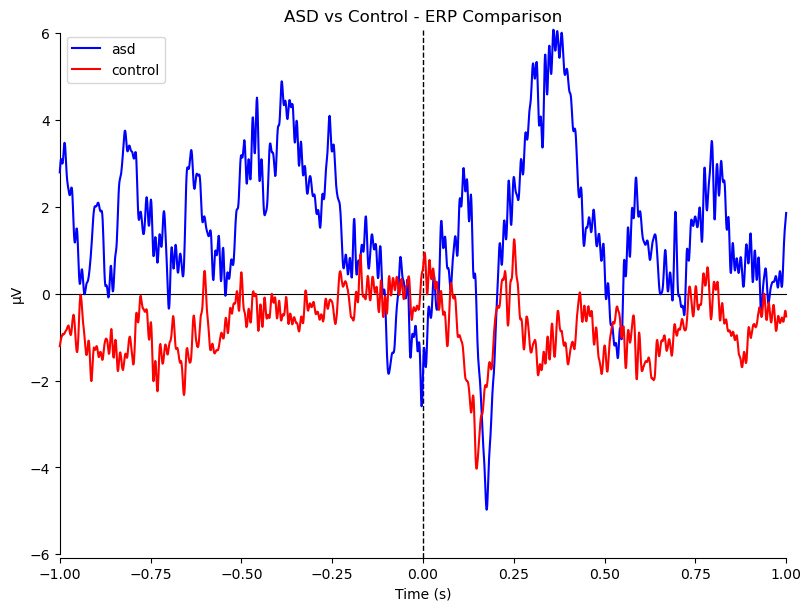

In [173]:
#Plot differences between ASD and Controls in conjuction
# Plot group differences
if not erp_df.empty:
    
    # Create evoked objects for each condition
    evoked_dict = {}
    
    for diagnosis in results_df['diagnosis'].unique():
        condition_data = erp_df[erp_df['diagnosis'] == diagnosis]
        
        if not condition_data.empty:
            # Compute grand average
            grand_avg = condition_data.groupby('time')['amplitude'].mean()
            times = grand_avg.index.values
            data = grand_avg.values.reshape(1, -1)
            # Create minimal info structure
            info = mne.create_info(['ROI'], sfreq=1000, ch_types=['eeg'])  
            
            # Create evoked object
            evoked = mne.EvokedArray(data, info, tmin=times[0])
            evoked_dict[diagnosis] = evoked
    if len(evoked_dict) == 2:
        # Plot comparison using MNE
        fig = plot_compare_evokeds(evoked_dict, picks='ROI', 
                                  title='ASD vs Control - ERP Comparison',
                                   colors=['blue', 'red'], ci=True, show='separate', show_sensors='upper right')
        plt.show()

In [179]:
results_df['set_size'] = results_df['set_size'].replace({5: 'set_five', 9: 'set_nine', 13: 'set_t'})

In [180]:
results_df

,subject,diagnosis,set_size,N1_amp,N1_lat,N1_chan,P3b_amp,P3b_lat,P3b_chan,alpha_power,gamma_power
0,1109P,asd,set_five,-0.000006,0.140,E87,0.000020,0.378,E59,3.243293e-09,1.157568e-10
1,1109P,asd,set_nine,-0.000012,0.118,E87,0.000019,0.312,E59,2.500041e-09,1.245039e-10
2,1109P,asd,set_t,-0.000009,0.128,E87,0.000018,0.400,E59,3.056893e-09,1.087700e-10
3,1109M1,control,set_five,-0.000004,0.132,E87,0.000005,0.432,E59,6.922079e-10,7.534543e-11
4,1109M1,control,set_nine,-0.000008,0.125,E53,0.000005,0.397,E92,8.221113e-10,7.696529e-11
5,1109M1,control,set_t,-0.000006,0.096,E53,0.000003,0.308,E87,8.221502e-10,7.397062e-11


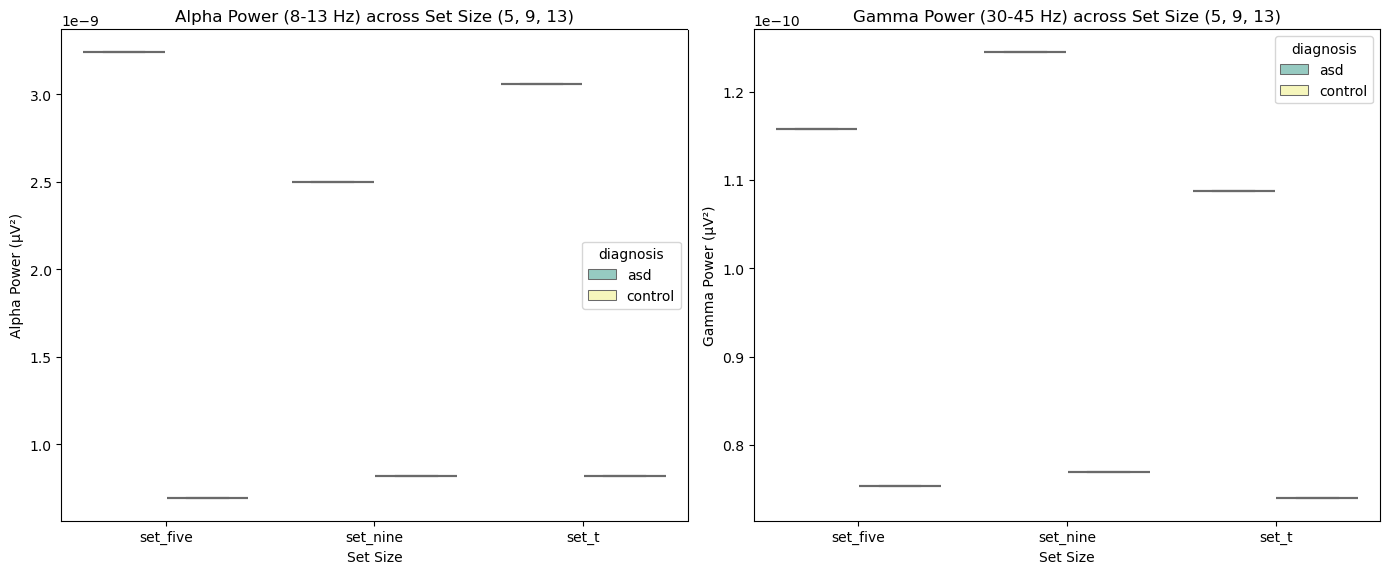

In [188]:
#Spectral power comparison
if not results_df.empty:
    # Alpha vs Gamma power comparison between conditions
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Alpha power
    ax1 = axes[0]
    valid_alpha = results_df.dropna(subset=['alpha_power'])
    if not valid_alpha.empty:
        sns.boxplot(data=valid_alpha, x='set_size', y='alpha_power', ax=ax1, hue='diagnosis', palette='Set3')
        ax1.set_title('Alpha Power (8-13 Hz) across Set Size (5, 9, 13)')
        ax1.set_ylabel('Alpha Power (μV²)')
        ax1.set_xlabel('Set Size')

    # Gamma power
    ax2 = axes[1]
    valid_gamma = results_df.dropna(subset=['gamma_power'])
    if not valid_gamma.empty:
        sns.boxplot(data=valid_gamma, x='set_size', y='gamma_power', ax=ax2, hue='diagnosis', palette='Set3')
        ax2.set_title('Gamma Power (30-45 Hz) across Set Size (5, 9, 13)')
        ax2.set_ylabel('Gamma Power (μV²)')
        ax2.set_xlabel('Set Size')

    plt.tight_layout()
    plt.show()

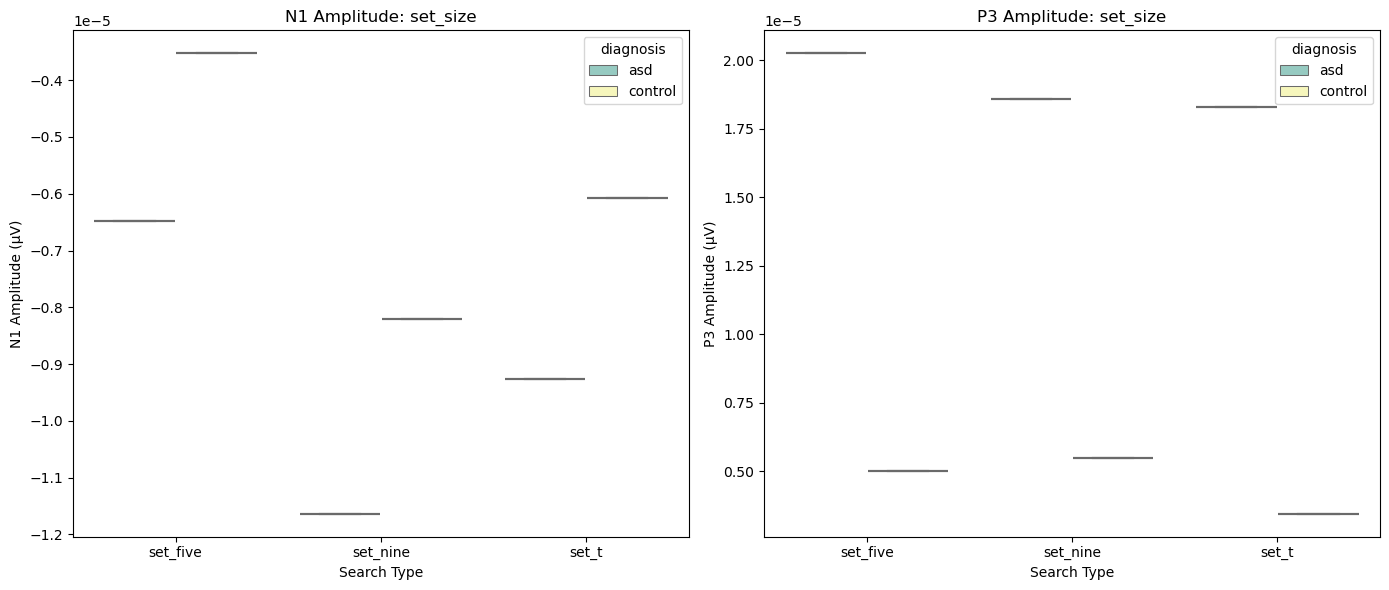

In [186]:
#Amplitude differences
# Plot differences in N1 and P3 amplitudes
if not results_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # N1 amplitude
    ax1 = axes[0]
    valid_n1 = results_df.dropna(subset=['N1_amp'])
    if not valid_n1.empty:
        sns.boxplot(data=valid_n1, x='set_size', y='N1_amp', ax=ax1, hue='diagnosis', palette='Set3')
        ax1.set_title('N1 Amplitude: set_size')
        ax1.set_ylabel('N1 Amplitude (μV)')
        ax1.set_xlabel('Search Type')

    # P3 amplitude
    ax2 = axes[1]
    valid_p3 = results_df.dropna(subset=['P3b_amp'])
    if not valid_p3.empty:
        sns.boxplot(data=valid_p3, x='set_size', y='P3b_amp', ax=ax2, hue='diagnosis', palette='Set3')
        ax2.set_title('P3 Amplitude: set_size')
        ax2.set_ylabel('P3 Amplitude (μV)')
        ax2.set_xlabel('Search Type')

    plt.tight_layout()
    plt.show()

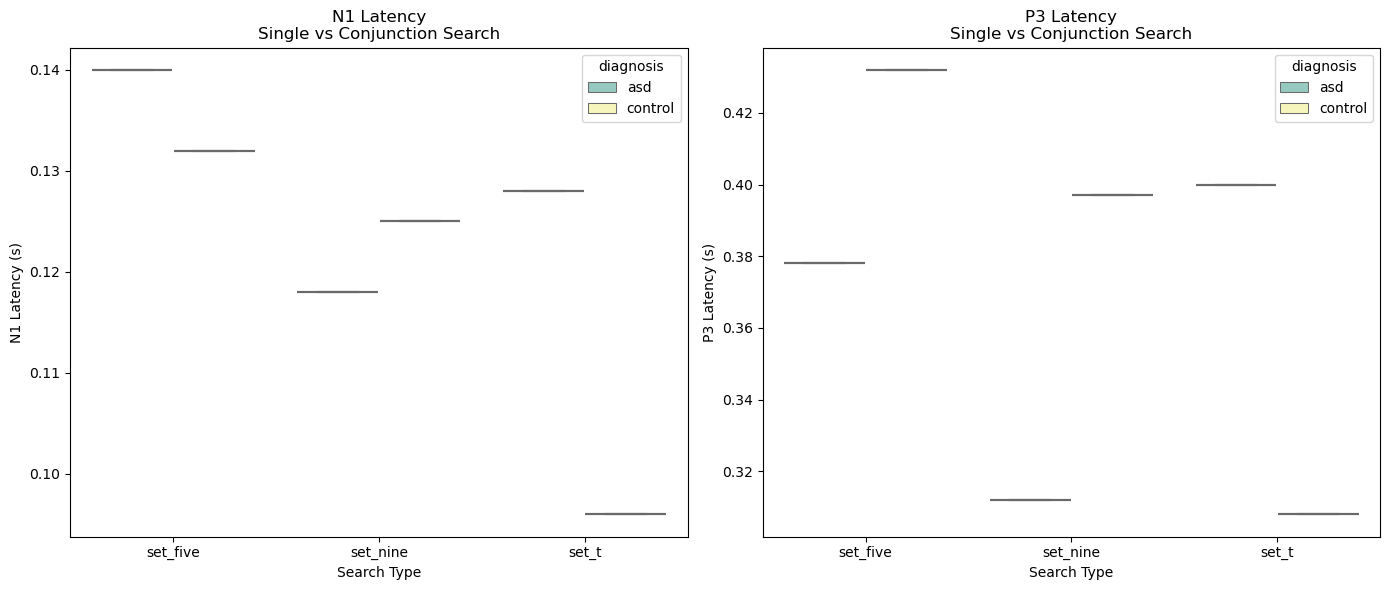

In [187]:
#Latency differences

# Plotting differences in N1 and P3 latencies   
if not results_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # N1 latency
    ax1 = axes[0]
    valid_n1 = results_df.dropna(subset=['N1_lat'])
    if not valid_n1.empty:
        sns.boxplot(data=valid_n1, x='set_size', y='N1_lat', ax=ax1, hue='diagnosis', palette='Set3')
        ax1.set_title('N1 Latency\nSingle vs Conjunction Search')
        ax1.set_ylabel('N1 Latency (s)')
        ax1.set_xlabel('Search Type')

    # P3 latency
    ax2 = axes[1]
    valid_p3 = results_df.dropna(subset=['P3b_lat'])
    if not valid_p3.empty:
        sns.boxplot(data=valid_p3, x='set_size', y='P3b_lat', ax=ax2, hue='diagnosis', palette='Set3')
        ax2.set_title('P3 Latency\nSingle vs Conjunction Search')
        ax2.set_ylabel('P3 Latency (s)')
        ax2.set_xlabel('Search Type')

    plt.tight_layout()
    plt.show()

### UNDERSTANDING EVENTS, KEYS AND ANNOTATIONS from fif and edf

In [63]:
import mne

# Load the EDF file
raw_fif = "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif"
epochs = mne.read_epochs(raw_fif, preload=True)
# Get the event matrix directly (samples × 3)
events = epochs.events

# See event types mapping (e.g., {'feature_CA': 1, 'conjunction_CS': 2, ...})
event_id = epochs.event_id

# Count occurrences
import numpy as np
from collections import Counter

event_counts = Counter(events[:, 2])  # third column is the event ID

# Map back to labels
label_counts = {label: event_counts[code] for label, code in event_id.items()}
print(label_counts)

Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
{'da5a': 2, 'da5c': 6, 'da5s': 1, 'da9a': 2, 'da9c': 4, 'da9s': 2, 'da_d': 26, 'datc': 9, 'db5a': 2, 'db5c': 5, 'db9a': 2, 'db9c': 5, 'db9s': 2, 'dbtc': 9, 'df5a': 2, 'df5c': 6, 'df5s': 1, 'df9a': 2, 'df9c': 5, 'df9s': 1, 'dftc': 9, 'dr5a': 2, 'dr5c': 6, 'dr5s': 2, 'dr9a': 2, 'dr9c': 6, 'dr9s': 1, 'drtc': 9, 'ga5a': 2, 'ga5c': 6, 'ga5s': 1, 'ga9c': 5, 'ga9s': 1, 'gatc': 9, 'gt5a': 1, 'gt5c': 5, 'gt5s': 2, 'gt9a': 2, 'gt9c': 6, 'gt9s': 0, 'gttc': 8, 'vs/display/search/a5/ca': 2, 'vs/display/search/a5/cc': 6, 'vs/display/search/a5/cs': 2, 'vs/display/search/a9/ca': 2, 'vs/display/search/a9/cc': 5, 'vs/display/search/a9/cs': 1, 'vs/display/search/at/cc': 9}


In [64]:
# Load the FIF file
raw_fif = "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif"
epochs = mne.read_epochs(raw_fif, preload=True)
# Get the event matrix directly (samples × 3)
events = epochs.events

# See event types mapping (e.g., {'feature_CA': 1, 'conjunction_CS': 2, ...})
event_id = epochs.event_id

# Count occurrences
import numpy as np
from collections import Counter

event_counts = Counter(events[:, 2])  # third column is the event ID

# Map back to labels
label_counts = {label: event_counts[code] for label, code in event_id.items()}
print(label_counts) 

Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
{'da5a': 2, 'da5c': 6, 'da5s': 1, 'da9a': 1, 'da9c': 6, 'da9s': 2, 'da_d': 27, 'datc': 9, 'db5a': 2, 'db5c': 6, 'db9a': 1, 'db9c': 6, 'db9s': 2, 'dbtc': 9, 'df5a': 2, 'df5c': 6, 'df5s': 2, 'df9a': 1, 'df9c': 6, 'df9s': 2, 'dftc': 9, 'dr5a': 2, 'dr5c': 6, 'dr5s': 2, 'dr9a': 1, 'dr9c': 6, 'dr9s': 2, 'drtc': 8, 'ga5a': 2, 'ga5c': 6, 'ga5s': 2, 'ga9c': 6, 'ga9s': 2, 'gatc': 9, 'gt5a': 2, 'gt5c': 6, 'gt5s': 2, 'gt9a': 1, 'gt9c': 6, 'gt9s': 2, 'gttc': 8, 'vs/display/search/a5/ca': 2, 'vs/display/search/a5/cc': 6, 'vs/display/search/a5/cs': 2, 'vs/display/search/a9/ca': 1, 'vs/display/search/a9/cc': 6, 'vs/display/search/a9/cs': 2, 'vs/display/search/at/cc': 8}


In [16]:
# Load EDF file
raw_edf = "/Users/audrey-annebeaudry/Downloads/sub-1009M1_ses-01_task-VS_run-1_eeg.edf"
raw = mne.io.read_raw_edf(raw_edf, preload=True)

# Get annotations
annotations = raw.annotations
descriptions = [a['description'] for a in annotations]

# Count how many of each type
annotation_counts = Counter(descriptions)
print(annotation_counts)

Extracting EDF parameters from /Users/audrey-annebeaudry/Downloads/sub-1009M1_ses-01_task-VS_run-1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 140999  =      0.000 ...   140.999 secs...
Counter({'eeg_DIN3': 60, 'eeg_DIN2': 60, 'bgn1': 30, 'da_d': 30, 'eeg_sync_time': 30, 'TRSP': 30, 'datc': 10, 'gatc': 10, 'dftc': 10, 'dstc': 10, 'gttc': 10, 'drtc': 10, 'dbtc': 10, 'da5c': 6, 'ga5c': 6, 'df5c': 6, 'ds5c': 6, 'gt5c': 6, 'dr5c': 6, 'db5c': 6, 'da9c': 6, 'ga9c': 6, 'df9c': 6, 'ds9c': 6, 'gt9c': 6, 'dr9c': 6, 'db9c': 6, 'BAD_LL_noisy': 2, 'da5s': 2, 'ga5s': 2, 'df5s': 2, 'ds5s': 2, 'gt5s': 2, 'dr5s': 2, 'da9s': 2, 'ga9s': 2, 'df9s': 2, 'ds9s': 2, 'gt9s': 2, 'dr9s': 2, 'db9s': 2, 'da5a': 2, 'ga5a': 2, 'df5a': 2, 'ds5a': 2, 'gt5a': 2, 'dr5a': 2, 'db5a': 2, 'da9a': 2, 'df9a': 2, 'ds9a': 2, 'gt9a': 2, 'dr9a': 2, 'db9a': 2, 'BAD_ACQ_SKIP': 1})


In [28]:
# ---------- Load and process FIF file ----------
raw_fif = "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif"
epochs = mne.read_epochs(raw_fif, preload=True)
event_id = epochs.event_id
events = epochs.events

# Only keep keys that contain 'gt'
gt_event_id = {k: v for k, v in event_id.items() if 'gt' in k.lower()}

# Filter event codes by key endings for 'ca', 'cs' (single) and 'cc' (conjunction)
single_codes = [code for key, code in gt_event_id.items() if key.endswith(('a', 's'))]
conjunction_codes = [code for key, code in gt_event_id.items() if key.endswith('c')]

# Count event codes in epochs
event_counts = Counter(events[:, 2])

# Sum counts for single and conjunction
fif_single_count = sum(event_counts.get(code, 0) for code in single_codes)
fif_conjunction_count = sum(event_counts.get(code, 0) for code in conjunction_codes)

print("FIF file event counts (Gaze-to-Target only):")
print(f"Single (ca + cs): {fif_single_count}")
print(f"Conjunction (cc): {fif_conjunction_count}")

# ---------- Load and process EDF file ----------
raw_edf = "/Users/audrey-annebeaudry/Downloads/sub-1009M1_ses-01_task-VS_run-1_eeg.edf"
raw = mne.io.read_raw_edf(raw_edf, preload=True)
annotations = raw.annotations
descriptions = [desc.lower().strip() for desc in annotations.description]

# Filter annotations that contain 'gt'
gt_descriptions = [desc for desc in descriptions if 'gt' in desc]

# Count based on suffix
edf_single_count = sum(1 for desc in gt_descriptions if desc.endswith(('a', 's')))
edf_conjunction_count = sum(1 for desc in gt_descriptions if desc.endswith('c'))

print("\nEDF file annotation counts (Gaze-to-Target only):")
print(f"Single (ca + cs): {edf_single_count}")
print(f"Conjunction (cc): {edf_conjunction_count}")

# ---------- Summary comparison ----------
print("\nComparison summary (Gaze-to-Target only):")
print(f"FIF single vs EDF single: {fif_single_count} vs {edf_single_count}")
print(f"FIF conjunction vs EDF conjunction: {fif_conjunction_count} vs {edf_conjunction_count}")

Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
FIF file event counts (Gaze-to-Target only):
Single (ca + cs): 7
Conjunction (cc): 20
Extracting EDF parameters from /Users/audrey-annebeaudry/Downloads/sub-1009M1_ses-01_task-VS_run-1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 140999  =      0.000 ...   140.999 secs...

EDF file annotation counts (Gaze-to-Target only):
Single (ca + cs): 8
Conjunction (cc): 22

Comparison summary (Gaze-to-Target only):
FIF single vs EDF single: 7 vs 8
FIF conjunction vs EDF conjunction: 20 vs 22


In [25]:
# Extract unique annotation descriptions
unique_annotations = set(raw.annotations.description)

print("Unique annotation labels in EDF:")
for label in sorted(unique_annotations):
    print(label)

Unique annotation labels in EDF:
BAD_ACQ_SKIP
BAD_LL_noisy
TRSP
bgn1
da5a
da5c
da5s
da9a
da9c
da9s
da_d
datc
db5a
db5c
db9a
db9c
db9s
dbtc
df5a
df5c
df5s
df9a
df9c
df9s
dftc
dr5a
dr5c
dr5s
dr9a
dr9c
dr9s
drtc
ds5a
ds5c
ds5s
ds9a
ds9c
ds9s
dstc
eeg_DIN2
eeg_DIN3
eeg_sync_time
ga5a
ga5c
ga5s
ga9c
ga9s
gatc
gt5a
gt5c
gt5s
gt9a
gt9c
gt9s
gttc


## Conjunction vs single search

Processing /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


Processing /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s finished


    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s finished


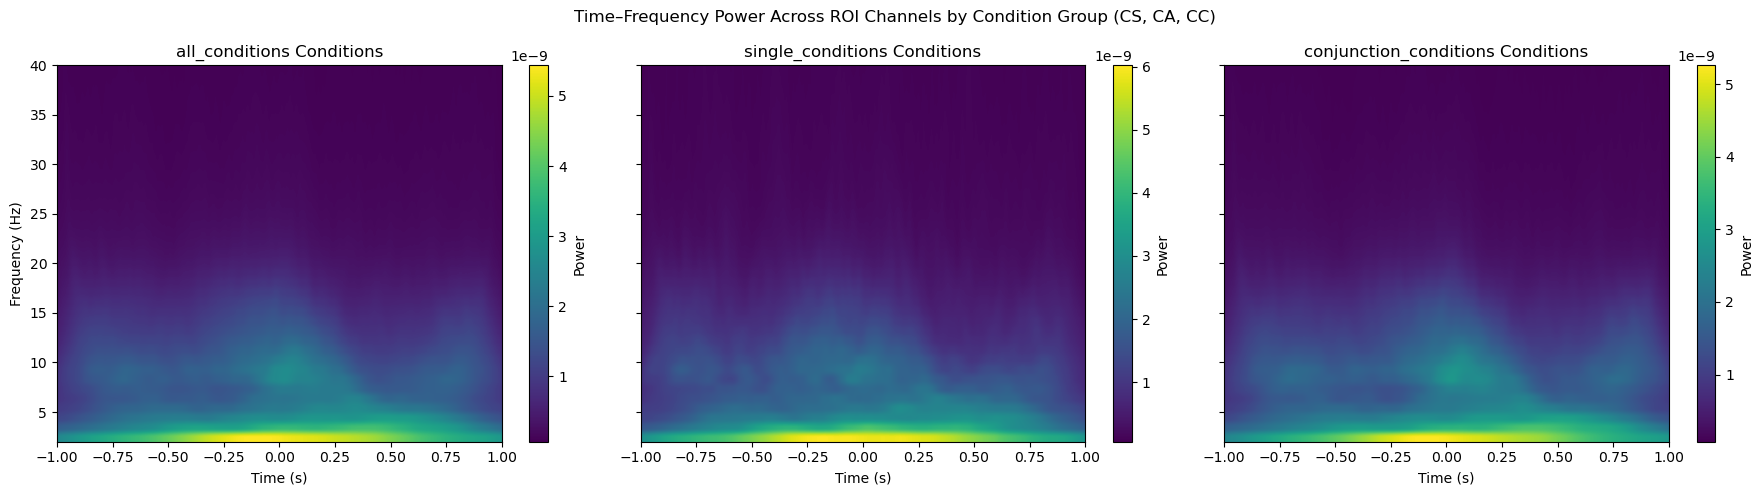

In [75]:
cs_conditions = [
    'vs/display/search/a5/cs',
    'vs/display/search/a9/cs',
    'vs/display/search/at/cs',
]

ca_conditions = [
    'vs/display/search/a5/ca',
    'vs/display/search/a9/ca',
    'vs/display/search/at/ca',
]

cc_conditions = [
    'vs/display/search/a5/cc',
    'vs/display/search/a9/cc',
    'vs/display/search/at/cc',
]

condition_sets = {
    'all_conditions': cs_conditions + ca_conditions + cc_conditions,
    'single_conditions': cs_conditions + ca_conditions,
    'conjunction_conditions': cc_conditions,
}

# --- EEG Files ---
epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]

# --- ROI Channels ---
roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

# --- Time-Frequency Parameters ---
freqs = np.arange(2, 41, 1)
n_cycles = 4

# --- Container for Averaged TFRs ---
group_tfr_data = {key: [] for key in condition_sets}

# --- Loop Over Files ---
for filepath in epoch_files:
    print(f"Processing {filepath}")
    ep = mne.read_epochs(filepath, preload=True)

    for group_label, cond_list in condition_sets.items():
        valid_conds = [cond for cond in cond_list if cond in ep.event_id]
        if not valid_conds:
            continue

        cond_epochs = ep[valid_conds].copy().pick_channels(roi_channels)

        # TFR using multitaper method
        tfr = mne.time_frequency.tfr_multitaper(
            cond_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            use_fft=True,
            return_itc=False,
            average=True
        )

        # Average across ROI channels (data shape: [n_channels, n_freqs, n_times])
        roi_mean = tfr.data.mean(axis=0)  # shape: (n_freqs, n_times)
        group_tfr_data[group_label].append(roi_mean)

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
times = tfr.times

for i, group_label in enumerate([ 'all_conditions','single_conditions','conjunction_conditions']):
    data_list = group_tfr_data[group_label]
    if data_list:
        mean_power = np.mean(data_list, axis=0)  # shape: (freqs, times)

        im = axes[i].imshow(
            mean_power, aspect='auto', origin='lower',
            extent=[times[0], times[-1], freqs[0], freqs[-1]],
            cmap='viridis'
        )

        axes[i].set_title(f"{group_label} Conditions")
        axes[i].set_xlabel('Time (s)')
        if i == 0:
            axes[i].set_ylabel('Frequency (Hz)')

        fig.colorbar(im, ax=axes[i], orientation='vertical', label='Power')

plt.suptitle("Time–Frequency Power Across ROI Channels by Condition Group (CS, CA, CC)")
plt.tight_layout()
plt.show()

Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


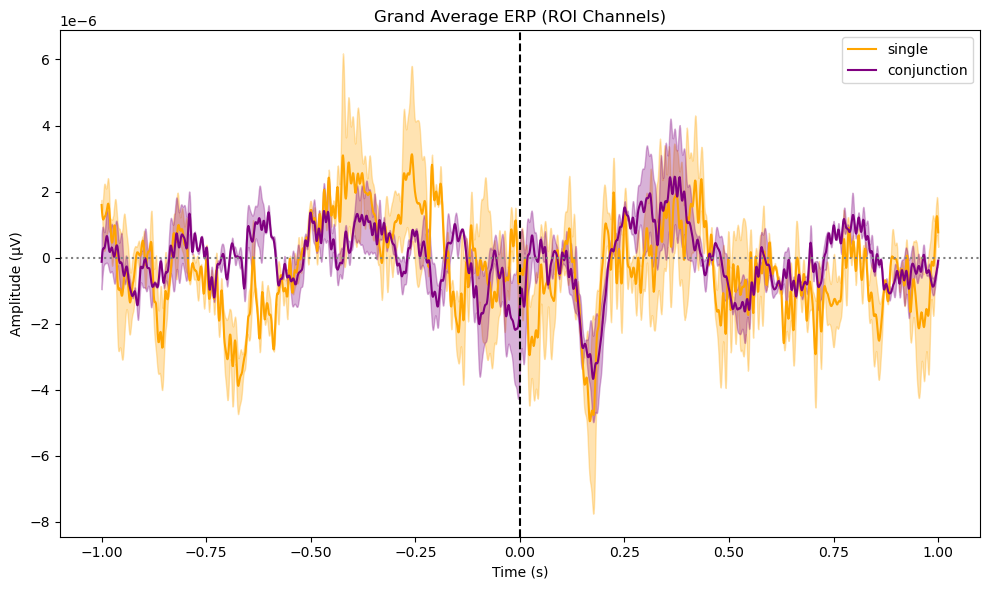

In [76]:
# Re-load epochs just for ERP waveform averaging
erp_by_detail = {'single': [], 'conjunction': []}
detail_conditions = {
    'single': ['vs/display/search/a5/cs', 'vs/display/search/a9/cs', 'vs/display/search/at/cs',
               'vs/display/search/a5/ca', 'vs/display/search/a9/ca', 'vs/display/search/at/ca'],
    'conjunction': ['vs/display/search/a5/cc', 'vs/display/search/a9/cc', 'vs/display/search/at/cc']
}

for filepath in epoch_files:
    ep = mne.read_epochs(filepath, preload=True)

    for detail, conds in detail_conditions.items():
        existing = [c for c in conds if c in ep.event_id]
        if not existing:
            continue
        epochs = ep[existing].copy().pick_channels(roi_channels)
        # Average across ROI channels and then across epochs
        erp_data = epochs.get_data().mean(axis=1).mean(axis=0)  # shape: (n_times,)
        erp_by_detail[detail].append(erp_data)

# Now average across participants
times = ep.times
plt.figure(figsize=(10, 6))
colors = {'single': 'orange', 'conjunction': 'purple'}

for detail in erp_by_detail:
    data = np.vstack(erp_by_detail[detail])  # shape: (n_subjects, n_times)
    mean = data.mean(axis=0)
    sem = data.std(axis=0) / np.sqrt(data.shape[0])
    plt.plot(times, mean, label=detail, color=colors[detail])
    plt.fill_between(times, mean - sem, mean + sem, color=colors[detail], alpha=0.3)

plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='gray', linestyle=':')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("Grand Average ERP (ROI Channels)")
plt.legend()
plt.tight_layout()
plt.show()

In [77]:
epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]
all_measures = [] 
for filepath in epoch_files:
    print(f"Processing {filepath}")
    ep = mne.read_epochs(filepath, preload=True)

    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'


    for cond_set_name, cond_list in condition_sets.items():
        # Filter conditions that exist in this file
        existing_conds = [c for c in cond_list if c in ep.event_id]
        if not existing_conds:
            print(f"No {cond_set_name} found in {filepath}, skipping.")
            continue

        condition_epochs = ep[existing_conds]

        # Average evoked for ROI channels
        evoked = condition_epochs.average(picks=roi_channels)

        # Get N1 peak (~100ms, negative peak)
        n1_chan, n1_lat, n1_amp = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)

        # Get P3b peak (~300-500ms, positive peak)
        p3_chan, p3_lat, p3_amp = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

        # Compute PSD using multitaper, EEG channels only
        picks = mne.pick_types(condition_epochs.info, eeg=True)
        psd = condition_epochs.compute_psd(method='multitaper', fmin=1, fmax=40, picks=picks)
        psds, freqs = psd.get_data(return_freqs=True)

        # Average across epochs
        avg_psd = psds.mean(axis=0)  # shape: (n_channels, n_freqs)

        picked_ch_names = [condition_epochs.ch_names[i] for i in picks]

        psd_df = pd.DataFrame(avg_psd, index=picked_ch_names, columns=freqs)

        # Band power calculation on ROI channels
        band_powers = {}
        for band_name, (fmin, fmax) in bands.items():
            try:
                band_power = psd_df.loc[roi_channels, (psd_df.columns > fmin) & (psd_df.columns < fmax)].mean().mean()
            except KeyError:
                band_power = None
            band_powers[band_name] = band_power

        # Append results
        all_measures.append({
            'subject': subject_id,
            'diagnosis': diagnosis,
            'condition_set': cond_set_name,
            'N1_amp': n1_amp,
            'N1_lat': n1_lat,
            'N1_chan': n1_chan,
            'P3b_amp': p3_amp,
            'P3b_lat': p3_lat,
            'P3b_chan': p3_chan,
            'alpha_power': band_powers.get('alpha'),
            'gamma_power': band_powers.get('gamma'),
        })

results_df = pd.DataFrame(all_measures)
results_df

Processing /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Processing /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
 

,subject,diagnosis,condition_set,N1_amp,N1_lat,N1_chan,P3b_amp,P3b_lat,P3b_chan,alpha_power,gamma_power
0,1109P,asd,all_conditions,-0.000005,0.135,E87,0.000013,0.381,E59,2.899331e-09,1.159023e-10
1,1109P,asd,single_conditions,-0.000009,0.080,E59,0.000015,0.381,E59,2.687133e-09,1.190531e-10
2,1109P,asd,conjunction_conditions,-0.000006,0.129,E87,0.000011,0.381,E59,2.973600e-09,1.147995e-10
3,1109M1,control,all_conditions,-0.000004,0.116,E53,0.000003,0.433,E59,7.252936e-10,7.473628e-11
4,1109M1,control,single_conditions,-0.000006,0.116,E53,0.000004,0.433,E59,5.599728e-10,7.317863e-11
5,1109M1,control,conjunction_conditions,-0.000004,0.098,E87,0.000003,0.428,E59,7.831558e-10,7.528146e-11
